# Etape 2 : Préparation des données pour notre algorithme de machine learning et Modélisation

In [107]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PolynomialFeatures,RobustScaler
from math import sqrt
from sklearn.compose import make_column_selector,make_column_transformer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import pickle5 as pickle
from sklearn.model_selection import learning_curve

In [108]:
df = pd.read_csv('data.csv')

## I) Préparation du modèle pour le Machine Learning

#### Introduction : Dans l'étape 1, on a séparer nos variables en deux catégories : quantitatives et catégorielles. Après avoir catégoriser ses variables,on va les transformer  pour qu'elles soient ajuster à notre modèle. 

#### One-Hot-Encoding  :  Pour transformer nos variables catégorielles on va utilise le one-hot encoding , on va convertir les valeurs associées à nos variables en de nouvelles colonnes de variables et on leur assigne une valeur binaire 1 pour présent et 0 pour non existant.

In [109]:
categorical_features = ['children','sex','smoker','region']

#### Scaling : Pour les variables quantitatives, on utilise des méthodes de scaling telle que la normalisation,standardization lorsqu'une des variables aura un poids plus élevé sur les autres.

In [110]:
numerical_features = ['age','bmi']

### 1. La magie des Pipelines

#### Une pipeline est une chaine de transformation ,elle va nous permettre de faire plusieurs action de transformation sur nos données.On a au préalables séparer nos variables en deux catégories les valeurs numériques et catégoriques, on va ainsi pouvoir créer deux pipelines. Ici notre target est les charges de l'assurance en fonction des autres paramètres.

In [111]:

my_num_pipe = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2)) 
preprocessor = ColumnTransformer([
    ("one_hot", OneHotEncoder(handle_unknown='ignore'),categorical_features),
    ("scaling", my_num_pipe, numerical_features)
])


## II) Modélisation

#### Après avoir créer notre premier transformeur composé des deux pipelines (OneHotEncoding,Standardisation), nous allons maintenant nous attaqué aux différents types de régression linéaire pour ajuster notre modèle.

In [112]:
X = df.drop('charges', axis=1)
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42)

## 1) Les algorithmes de Régression

### A) La Régression Linéaire

In [113]:
lr_pipeline = make_pipeline(preprocessor,LinearRegression())
lr_pipeline.fit(X_train,y_train)
lr_pipeline.score(X_test,y_test)


0.7775710489429823

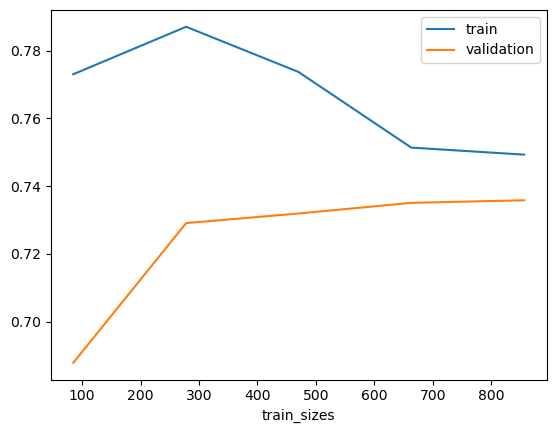

In [114]:
x =learning_curve(lr_pipeline,X_train,y_train,return_times=True)


plt.plot(x[0], x[1].mean(axis=1), label='train')
plt.plot(x[0], x[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

### B) Le Lasso Régression

In [115]:
lasso_pipeline = make_pipeline(preprocessor,Lasso(alpha=0.54))
lasso_pipeline.fit(X_train,y_train)
lasso_pipeline.score(X_test,y_test)


0.7801273533984141

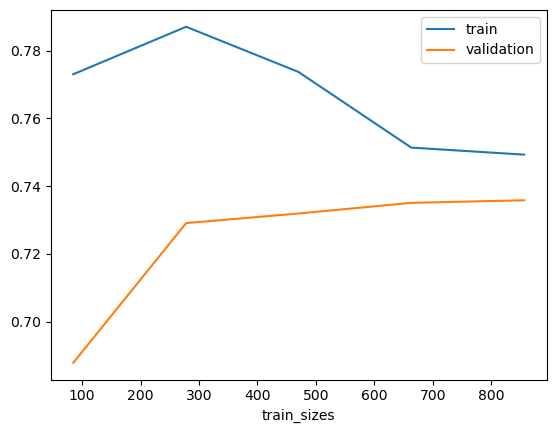

In [116]:
z =learning_curve(lr_pipeline,X_train,y_train,return_times=True)


plt.plot(z[0], z[1].mean(axis=1), label='train')
plt.plot(z[0], z[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [117]:
lasso_pred = lasso_pipeline.predict(X_train)


In [118]:
residual_lasso = (y_train - lasso_pred).abs().sort_values()
residual_lasso

737         2.031425
555         2.996031
60          3.757846
1200        4.776311
1185        5.288283
            ...     
242     23708.189402
219     24148.814378
819     24297.587319
577     26099.508478
1300    30347.313800
Name: charges, Length: 1070, dtype: float64

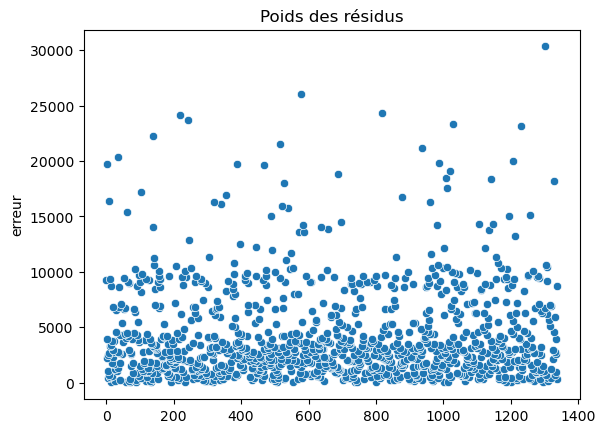

In [119]:
sns.scatterplot( residual_lasso)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

#### B.2) A la Recherche d'un meilleur alpha

In [129]:
lasso_alphas={"lasso__alpha":np.arange(55.00,56.00,0.01)}
model_lasso = GridSearchCV(estimator = lasso_pipeline,cv=5,scoring="r2",param_grid=lasso_alphas)
model_lasso.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['children',
                                                                          'sex',
                                                                          'smoker',
                                                                          'region']),
                                                                        ('scaling',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['age',
                                                                          'bmi'])])),
                                       ('lasso',
                                        Lasso(alpha=55.0, random_state=42)...
       55.36, 55.37, 55.38, 55.39, 55.4 , 55.41, 55.42, 55.43, 55.44,
       55.45, 55.46, 55.47, 55.48, 55.49, 55.5 , 55.51, 55.52, 55.53,
       55.54, 55.55, 55.56, 55.57, 55.58, 55.59, 55.6 , 55.61, 55.62,
       55.63, 55.64, 55.65, 55.66, 55.67, 55.68, 55.69, 55.7 , 55.71,
       55.72, 55.73, 55.74, 55.75, 55.76, 55.77, 55.78, 55.79, 55.8 ,
       55.81, 55.82, 55.83, 55.84, 55.85, 55.86, 55.87, 55.88, 55.89,
       55.9 , 55.91, 55.92, 55.93, 55.94, 55.95, 55.96, 55.97, 55.98,
       55.99])},
             scoring='r2')

In [130]:
model_lasso.best_params_

{'lasso__alpha': 55.0}

In [122]:
bl_alpha=model_lasso.best_params_['lasso__alpha']
bl_alpha

55.0

##### Test avec le nouveau alpha

In [131]:
lasso_pipeline = make_pipeline(preprocessor,Lasso(random_state=42,alpha=bl_alpha))
lasso_pipeline.fit(X_train,y_train)
lasso_pipeline.score(X_test, y_test)

0.779668711166942

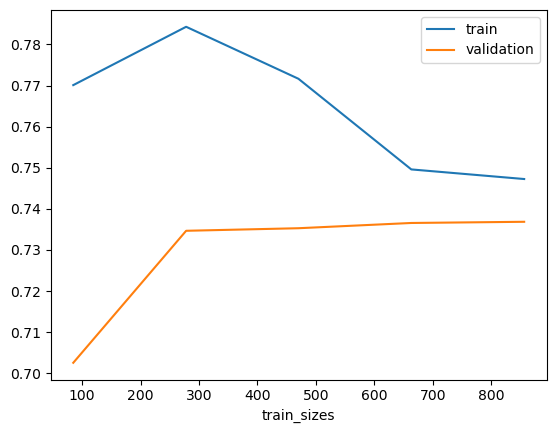

In [124]:
x =learning_curve(lasso_pipeline,X_train,y_train,return_times=True)
plt.plot(x[0], x[1].mean(axis=1), label='train')
plt.plot(x[0], x[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

### C)Le Ridge Regression

In [125]:

R_pipeline = make_pipeline(preprocessor,Ridge(alpha=7.5))
R_pipeline.fit(X_train,y_train)
R_pipeline.score(X_test,y_test)


0.7789770022868325

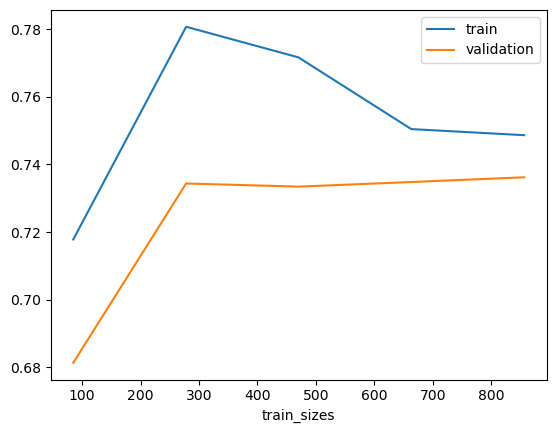

In [126]:
y =learning_curve(R_pipeline,X_train,y_train,return_times=True)


plt.plot(y[0], y[1].mean(axis=1), label='train')
plt.plot(y[0], y[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

### D) Elastic Regression

In [127]:
eN_pipeline= make_pipeline(preprocessor,ElasticNet(alpha=0.0001))
eN_pipeline.fit(X_train,y_train)
eN_pipeline.score(X_test, y_test)

/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e+10, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(


0.7801252285694217

/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.743e+08, tolerance: 1.405e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.687e+09, tolerance: 4.702e+06
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

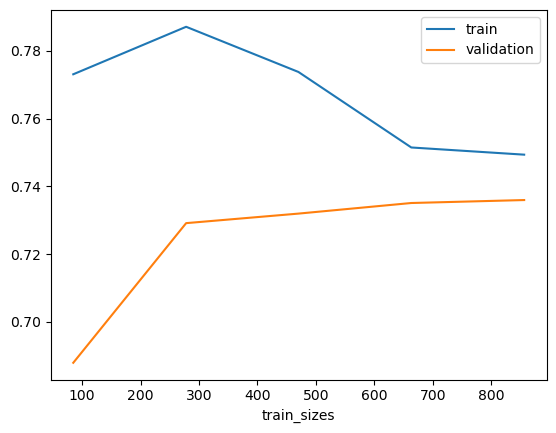

In [128]:
w =learning_curve(eN_pipeline,X_train,y_train,return_times=True)
plt.plot(w[0], w[1].mean(axis=1), label='train')
plt.plot(w[0], w[2].mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()